# Online TIS generation to reproduce Fig. 4

In [10]:
import sys, os
sys.path.append("..")
import scipy.io as scio
import seaborn as sns
from pathlib import Path

TUBE_DIR = Path.cwd().parent
ROOT_DIR = TUBE_DIR.parent
sys.path.append(os.path.join(TUBE_DIR))
sys.path.append(os.path.join(ROOT_DIR))
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from utils.frt import adv_sample_params, sample_pts_in_ellipsoid
from Deepkoopman.Utility import data_collecter, Linear2D, set_seed
import time

In [11]:
set_seed(2024)

env_name = "Linear2D"
suffix = "Linear2D0221_1"
method = "KoopmanIU"

org_system = Linear2D()
device = torch.device("cuda")
# Load network
root_path = "../Deepkoopman/Data/" + suffix
print(method)
if method.endswith("KoopmanU"):
    from Deepkoopman.train import DKU as lka
elif method.endswith("KoopmanIU"):
    from Deepkoopman.train import DIKU as lka

for file in os.listdir(root_path):
    if file.startswith(method + "_") and file.endswith(".pth"):
        model_path = file
Data_collect = data_collecter(env_name)
udim = Data_collect.udim
Nstates = Data_collect.Nstates
dicts = torch.load(root_path + "/" + model_path, map_location=device)
state_dict = dicts["model"]
if method.endswith("KoopmanU"):
    layer = dicts["layer"]
    NKoopman = layer[-1] + Nstates
    ko_system = lka.Network(layer, NKoopman, udim)
elif method.endswith("KoopmanIU"):
    elayer = dicts["Elayer"]
    ilayer = dicts["Ilayer"]
    inn_config = dicts["INNconfig"]
    NKoopman = elayer[-1] + Nstates
    ko_system = lka.Network(Nstates, udim, elayer, ilayer, inn_config,device)
    ko_system.masks = dicts["mask"]
    ko_system.construct_net()
ko_system.load_state_dict(state_dict)
ko_system.to(device)
print("checkpoints loaded!")
ko_system.double()


def sample_controls(org_system, N_MC, T, device):
    us = np.repeat(
        np.random.uniform(
            org_system.umin, org_system.umax, size=(N_MC, 1, org_system.u_dim)
        ),
        axis=1,
        repeats=T,
    )
    return torch.from_numpy(us).to(device)  # (N_MC, N, n_x)

KoopmanIU
checkpoints loaded!


In [12]:
def plot_compare_inst(ax, k, idx, T, time_instant, forward, colors):
    RS = "FRS" if forward else "BRS"
    print("time_step:{}s".format(k * org_system.dt))

    ax.scatter(
        Z_randUP[:, k, idx[0]], Z_randUP[:, k, idx[1]], color=colors[0], alpha=0.1
    )
    hull = ConvexHull(Z_randUP[:, k, idx])
    for simplex in hull.simplices:
        ax.plot(
            Z_randUP[simplex, k, idx[0]], Z_randUP[simplex, k, idx[1]], color=colors[0]
        )
    ax.plot(
        Z_randUP[simplex, k, idx[0]],
        Z_randUP[simplex, k, idx[1]],
        color=colors[0],
        label="Ours",
    )
    print("2D Vol rand =", hull.volume)

    if k == 0 and RS == "FRS":
        pass
    elif k == T and RS == "BRS":
        pass
    else:
        ax.scatter(
            Z_robUP[:, k, idx[0]], Z_robUP[:, k, idx[1]], color=colors[1], alpha=0.1
        )
        hull1 = ConvexHull(Z_robUP[:, k, idx])
        ax.plot(
            Z_robUP[hull1.vertices, k, idx[0]],
            Z_robUP[hull1.vertices, k, idx[1]],
            color=colors[1],
            label="Ours(AS)",
        )
        print("2D Vol rod =", hull1.volume)

    # center
    center = np.mean(Z_randUP, 0)[k, idx]  # (T+1, x_dim)
    ax.scatter(center[0], center[1], color="r", s=100)

    # ET toolbox
    et_path = "./baseline/{}/slice_{}s.mat".format(RS, int(time_instant))
    x = scio.loadmat(et_path)["X"]
    ax.plot(x[0, :], x[1, :], color=colors[2], label="ET")

    # Baseline
    bl_path = "./baseline/{}/ellipse3D.mat".format(RS)
    xx = scio.loadmat(bl_path)["X"]  # -5s~0s
    yy = scio.loadmat(bl_path)["Y"]
    k = T - k if forward else k
    ax.plot(xx[:, k], yy[:, k], color=colors[3], label="RHJB")  # 0s~5s

    # True ellipsoid
    if (T - k) % 20 == 0:
        hjb_path = "groundtruth/{}/HJB_results{}.mat".format(RS, T - k)
        contours = scio.loadmat(hjb_path)["contours"]
        ax.plot(contours[0, :], contours[1, :], "k-", label="Groundtruth")


# reachable sets during T time steps
def plot_compare_prid(ax, T, idx, test_step, forward, colors):
    RS = "FRS" if forward else "BRS"
    bl_path = "./baseline/{}/ellipse3D.mat".format(RS)
    tt = scio.loadmat(bl_path)["tMat"]
    xx = scio.loadmat(bl_path)["X"]
    yy = scio.loadmat(bl_path)["Y"]
    dur = -tt if forward else tt
    ax.plot_surface(dur, xx, yy, alpha=0.1, color=colors[3], shade=True, label="RHJB")

    for k in range(0, T + 1):
        hull_randUP = ConvexHull(Z_randUP[:, k, idx])
        for id, simplex in enumerate(hull_randUP.simplices):
            ax.plot(
                np.array([k * org_system.dt, k * org_system.dt])
                if forward
                else np.array([k * org_system.dt, k * org_system.dt])
                - T * org_system.dt,
                Z_randUP[simplex, k, idx[0]],
                Z_randUP[simplex, k, idx[1]],
                color=colors[0],
                label="Ours" if k == 0 and id == 0 else None,
                lw=0.5,
            )

        if k == 0 and RS == "FRS":
            pass
        elif k == T and RS == "BRS":
            pass
        else:
            hull = ConvexHull(Z_robUP[:, k, idx])
            for id, simplex in enumerate(hull.simplices):
                ax.plot(
                    np.array([k * org_system.dt, k * org_system.dt])
                    if forward
                    else np.array([k * org_system.dt, k * org_system.dt])
                    - T * org_system.dt,
                    Z_robUP[simplex, k, idx[0]],
                    Z_robUP[simplex, k, idx[1]],
                    color=colors[1],
                    label="Ours(AS)" if k == 0 and id == 0 else None,
                    lw=0.5,
                )

        if (T - k) % 20 == 0:
            if forward:
                time_instant = int((T - k) / 20)
                et_path = "./baseline/{}/slice_{}s.mat".format(RS, int((T - k) / 20))
                k = T - k
            else:
                time_instant = int((T - k) / 20) - 5
                et_path = "./baseline/{}/slice_{}s.mat".format(RS, int((T - k) / 20))

            hjb_path = "groundtruth/{}/HJB_results{}.mat".format(RS, k)
            contours = scio.loadmat(hjb_path)["contours"]
            ax.plot(
                np.repeat(time_instant, contours[0, :].shape),
                contours[0, :],
                contours[1, :],
                "k-",
                lw=2,
            )
            ax.plot(dur[:, k], xx[:, k], yy[:, k], color=colors[3], lw=0.5)

            x = scio.loadmat(et_path)["X"]
            ax.plot(
                np.repeat(time_instant, x[0, :].shape),
                x[0, :],
                x[1, :],
                color=colors[2],
                label="ET",
            )

    ax.set_xlabel("t")
    ax.set_ylabel(r"$x_1$")
    ax.set_zlabel(r"$x_2$")

# Forward reachable sets

In [13]:
# parameters
T = 100
forward = True
num_samples = 1000
x0 = np.array([-2, 1])  # initial state
Q_init = 0.01 * np.eye(2) 
org_system.Q = Q_init.copy()
x0_MC = sample_pts_in_ellipsoid(x0, Q_init, num_samples).T
org_system.x0_MC = x0_MC.copy()

z0 = ko_system.encode(torch.DoubleTensor(x0).to(device)).flatten()
z0_MC = ko_system.encode(torch.DoubleTensor(x0_MC).to(device))
ko_system.z0_MC = z0_MC.clone().detach()
ko_system.eta_z0s = 0.015
ko_system.eta_ctrl = 1

ko_system.z0 = z0.clone().detach()
us = sample_controls(org_system, num_samples, T, device)
ko_system.ctrl_MC = us.clone().detach()

In [14]:
# (randUP) in torch
# simulate forward
Z_randUP = torch.zeros(
    (num_samples, T + 1, NKoopman), dtype=torch.double, device=device
)
Z_randUP_dx = torch.zeros(
    (num_samples, T, Nstates, NKoopman), dtype=torch.double, device=device
)
Z_randUP_du = torch.zeros(
    (num_samples, T, Nstates, udim), dtype=torch.double, device=device
)

Z_randUP[:, 0, :] = z0_MC.clone().detach()
Z_robUP = torch.zeros((num_samples, T + 1, NKoopman), dtype=torch.double, device=device)

u = us[:, 0, :]  # (N_MC, u_dim)
ST_FRS = time.time()
for t in range(T):
    z_mc = Z_randUP[:, t, :]
    z_mc.requires_grad = True
    u.requires_grad = True
    z = ko_system.forward(z_mc, u)
    z_dz = torch.cat(
        [
            torch.autograd.grad(z[:, i].sum(), z_mc, retain_graph=True)[0][..., None, :]
            for i in range(Nstates)
        ],
        -2,
    )

    z_du = torch.cat(
        [
            torch.autograd.grad(z[:, i].sum(), u, retain_graph=(i + 1 < NKoopman))[0][
                ..., None, :
            ]
            for i in range(Nstates)
        ],
        -2,
    )
    Z_randUP[:, t + 1, :] = z.clone().detach()
    Z_randUP_dx[:, t, :, :] = z_dz.clone().detach()
    Z_randUP_du[:, t, :, :] = z_du.clone().detach()
Z_randUP = Z_randUP.cpu().detach().numpy()
Z_randUP_dx = Z_randUP_dx.cpu().detach().numpy()
Z_randUP_du = Z_randUP_du.cpu().detach().numpy()

# rodUP: resample the KO system's initial states and controls
adv_sample_params(
    org_system, ko_system, Z_randUP, Z_randUP_dx, Z_randUP_du, forward, device
)

Z_robUP[:, 0, :] = ko_system.z0_MC
for t in range(T):
    Z_robUP[:, t + 1, :] = ko_system.forward(
        Z_robUP[:, t, :], ko_system.ctrl_MC[:, t, :]
    )
print("Time cost of FRS:", time.time() - ST_FRS)
Z_robUP = Z_robUP.cpu().detach().numpy()

Time cost of FRS: 0.16258454322814941


time_step:0.0s
2D Vol rand = 0.030153579900651473
time_step:1.0s
2D Vol rand = 0.24070283727530606
2D Vol rod = 3.3711977013661394
time_step:2.0s
2D Vol rand = 0.5377752419980402
2D Vol rod = 6.452265302332343
time_step:3.0s
2D Vol rand = 0.9690869922973305
2D Vol rod = 10.93284425594405
time_step:4.0s
2D Vol rand = 1.632497805035976
2D Vol rod = 17.15706242030622
time_step:5.0s
2D Vol rand = 2.7411097604791697
2D Vol rod = 25.78646069915024


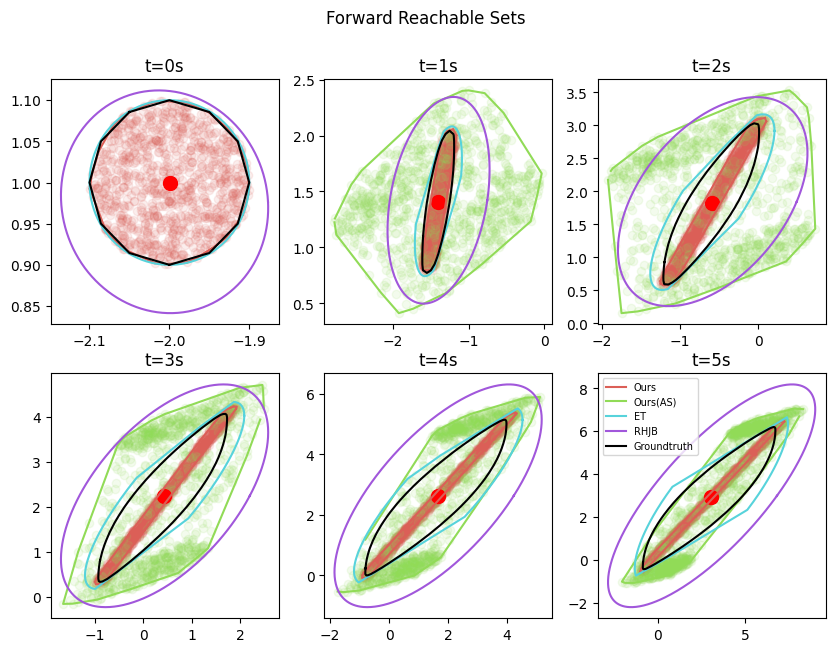

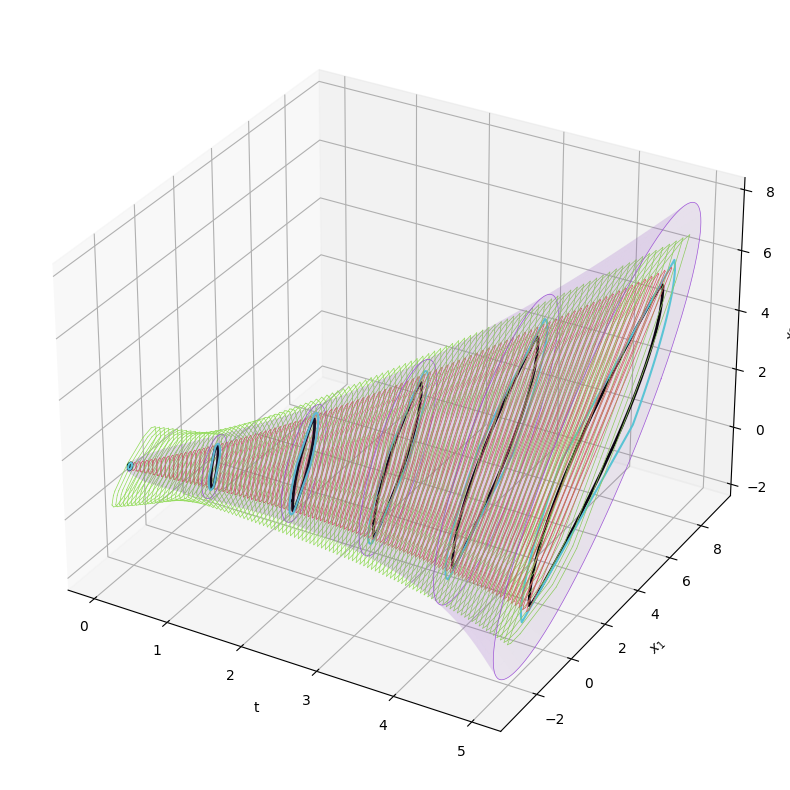

In [15]:
idx = [0, 1]  # dimensions of system to plot
test_step = 10  # dt =0.05*test_step
k = 0
colors = sns.color_palette("hls", 4)

plt.figure(figsize=(10, 7))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    time_instant = k * org_system.dt * test_step
    plot_compare_inst(ax, k * test_step, idx, T, time_instant, forward, colors)
    plt.title("t={}s".format(int(time_instant)))
    k += 2
ax.legend(prop={"size": 7})
plt.suptitle("Forward Reachable Sets")
plt.savefig("Results/FRS.png")
plt.show()

plt.figure(figsize=(20, 10))
ax1 = plt.subplot(projection="3d")
plot_compare_prid(ax1, T, idx, test_step, forward, colors)
plt.savefig("Results/FRT.png")
plt.show()

# Backward reachable sets

In [16]:
# parameters
forward = False
xT = np.array([0.0, 0.0])  # initial state
Q_init = np.eye(2) / 4
org_system.Q = Q_init.copy()
org_system.s0 = xT.copy()
xT_MC = sample_pts_in_ellipsoid(xT, Q_init, num_samples).T

ko_system.eta_z0s = 0.04
ko_system.eta_ctrl = 1
zT = ko_system.encode(torch.DoubleTensor(xT).to(device)).flatten()
zT_MC = ko_system.encode(torch.DoubleTensor(xT_MC).to(device))
ko_system.z0_MC = zT_MC.clone().detach()
ko_system.z0 = zT.clone().detach()
us = sample_controls(org_system, num_samples, T, device)
ko_system.ctrl_MC = us.clone().detach()

In [17]:
# simulate backward
Z_randUP = torch.zeros(
    (num_samples, T + 1, NKoopman), dtype=torch.double, device=device
)
Z_randUP_dx = torch.zeros(
    (num_samples, T, Nstates, NKoopman), dtype=torch.double, device=device
)
Z_randUP_du = torch.zeros(
    (num_samples, T, Nstates, udim), dtype=torch.double, device=device
)
Z_randUP[:, -1, :] = zT_MC.clone().detach()
Z_robUP = torch.zeros((num_samples, T + 1, NKoopman), dtype=torch.double, device=device)


u = us[:, 0, :]
ST_BRS = time.time()
for t in range(T, 0, -1):
    z_mc = Z_randUP[:, t, :]
    z_mc.requires_grad = True
    u.requires_grad = True
    z = ko_system.inverse(z_mc, u)
    z_dz = torch.cat(
        [
            torch.autograd.grad(z[:, i].sum(), z_mc, retain_graph=True)[0][..., None, :]
            for i in range(Nstates)
        ],
        -2,
    )

    z_du = torch.cat(
        [
            torch.autograd.grad(z[:, i].sum(), u, retain_graph=(i + 1 < NKoopman))[0][
                ..., None, :
            ]
            for i in range(Nstates)
        ],
        -2,
    )
    Z_randUP[:, t - 1, :] = z.clone().detach()
    Z_randUP_dx[:, t - 1, :, :] = z_dz.clone().detach()
    Z_randUP_du[:, t - 1, :, :] = z_du.clone().detach()
Z_randUP = Z_randUP.cpu().detach().numpy()
Z_randUP_dx = Z_randUP_dx.cpu().detach().numpy()
Z_randUP_du = Z_randUP_du.cpu().detach().numpy()

# resample the KO system's initial states and controls
adv_sample_params(
    org_system, ko_system, Z_randUP, Z_randUP_dx, Z_randUP_du, forward, device
)
# simulate forward

Z_robUP[:, -1, :] = ko_system.z0_MC
for t in range(T, 0, -1):
    Z_robUP[:, t - 1, :] = ko_system.inverse(
        Z_robUP[:, t, :], ko_system.ctrl_MC[:, t - 1, :]
    )
print("Time cost of BRS:", time.time() - ST_BRS)
Z_robUP = Z_robUP.cpu().detach().numpy()

Time cost of BRS: 0.16159391403198242


time_step:0.0s
2D Vol rand = 4.106855781998415
2D Vol rod = 14.190914353480954
time_step:1.0s
2D Vol rand = 3.438045966931021
2D Vol rod = 12.723803402891663
time_step:2.0s
2D Vol rand = 2.742528391719567
2D Vol rod = 10.938280230987877
time_step:3.0s
2D Vol rand = 2.0475415165526765
2D Vol rod = 9.004325533721637
time_step:4.0s
2D Vol rand = 1.3669915121641714
2D Vol rod = 7.044432795099224
time_step:5.0s
2D Vol rand = 0.7586130796940527


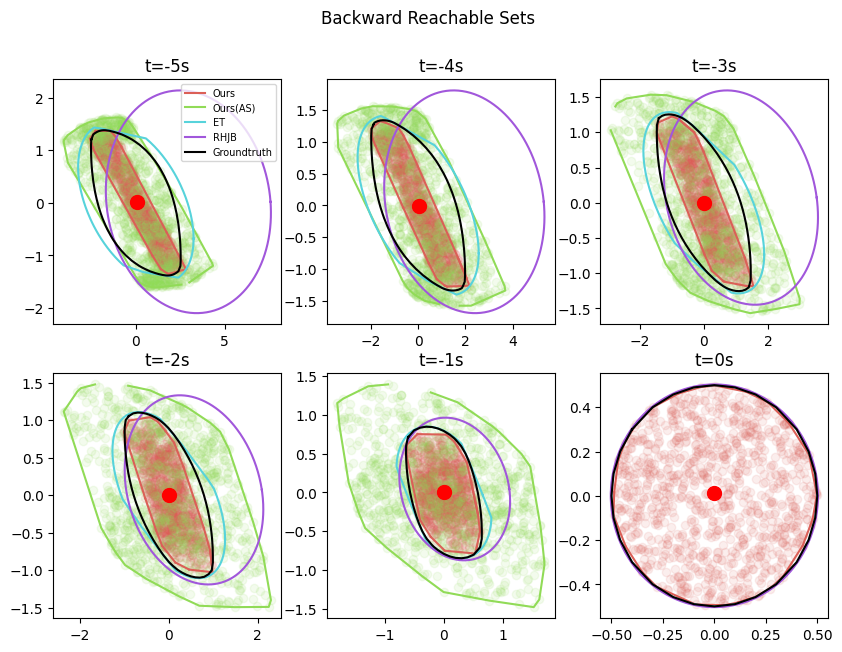

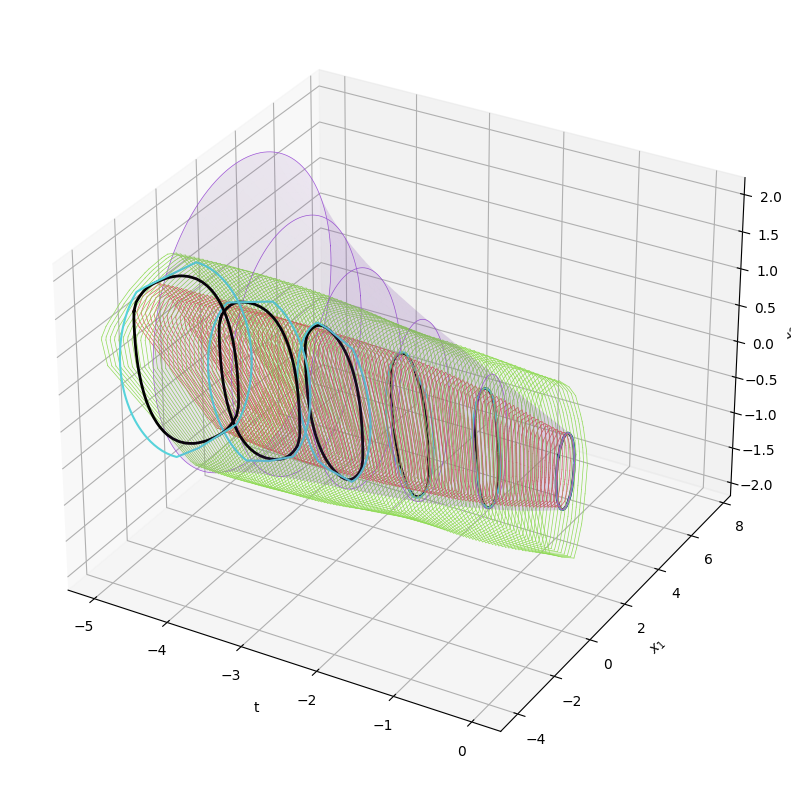

In [18]:
idx = [0, 1]  # dimensions of system to plot
test_step = 10  # dt =0.05*test_step
k = 0

plt.figure(figsize=(10, 7))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    time_instant = k * org_system.dt * test_step
    plot_compare_inst(ax, k * test_step, idx, T, time_instant, forward, colors)
    if i == 0:
        ax.legend(prop={"size": 7}, loc="upper right")
    plt.title("t={}s".format(round(time_instant - T * org_system.dt)))
    k += 2
plt.suptitle("Backward Reachable Sets")
plt.savefig("Results/BRS.png")
plt.show()

plt.figure(figsize=(20, 10))
ax1 = plt.subplot(projection="3d")
plot_compare_prid(ax1, T, idx, test_step, forward, colors)
ax.legend(prop={"size": 8})
plt.savefig("Results/BRT.png")
plt.show()